*Reinforcement learning (2023-2024)*
 - Temporal Difference (TD)
 - SARSA Algorithm
 - Q-Learning Algorithm

*Presented by: Reza Saadatyar*
*E-mail: Reza.Saadatyar92@gmail.com*

In [93]:
import time
import imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

**Functions**

In [303]:
# ================================================ Environment ========================================
def environment (all_states, all_states_j, all_actions_k, terminal_state):
    state1, state2 = all_states_j
    action1, action2 = all_actions_k                            # Plane velocity in vertical and horizontal directions
    new_state = [state1 + action1, state2 + action2]
    if np.sum(np.all(np.equal(new_state, all_states), axis=1)): # Check new state in all states
        if (new_state == terminal_state).all():
            reward = 10
        else:
            reward = -1
    else:
        new_state = all_states_j
        reward = -10
    return new_state, reward
# ================================================== Plot ==============================================
def plot(plan, all_states, all_actions,policy, FinalTimeStep,gamma, epsilon, dis, start_state, terminal_state, Q_prediction, alpha, type, plot_gif):
    !mkdir Images
    if plot_gif:
        FinalTimeStep = plan.shape[0]*plan.shape[1]

    states = np.zeros((FinalTimeStep , 2), dtype=int)
    actions = np.zeros((FinalTimeStep , 2),  dtype=int)
    rewards = np.zeros((FinalTimeStep , 1))
    i = 0
    if np.size(start_state)==2:
        states[0 , :] = start_state
    else:
        states[0,:]=start_state[0,0:2]
    if dis:
        fig, ax = plt.subplots(figsize=(4,4))
    filenames = []

    while 1:
        if i > FinalTimeStep -2:
            break
        if dis:
            plan2 = np.copy(plan)
            plan2[states[i, 0], states[i, 1]] = 3  # 3: Change the color start state
            plan2[terminal_state[0], terminal_state[1]] = 2  # 2: Change the color terminal state
            ax.cla()
            ax.imshow(plan2, cmap='winter')
            plt.title([f"gamma: {gamma}; alpha: {alpha}; Time Step {i}; {type}"],fontsize=8)
            plt.text(start_state[1] - 0.4, start_state[0], 'Start', fontsize=10, color='r', fontweight='bold')
            plt.text(terminal_state[1] - 0.3, terminal_state[0], 'End', fontsize=10, color='r', fontweight='bold')
            display(fig)
            clear_output(wait=True)
            if i == 0:
               time.sleep(1)
            else:
               time.sleep(0.3)

            if plot_gif:
                filename = f'Images/{i}.png'
                filenames.append(filename)
                plt.savefig(filename, facecolor='white', )

        if np.random.rand(1)>epsilon:
            Ind = policy[np.argmax(np.sum(np.equal(all_states, states[i, :]), axis=1))]
        else:
            Ind = np.random.randint(low=0, high=all_actions.shape[0], size=1)

        if (Q_prediction==1) and (i==0):
            actions[i, :] = start_state[0,2:4]
        else:
            actions[i, :] = all_actions[Ind, :]

        [states[i + 1], rewards[i + 1, :]] = environment(all_states, states[i, :], actions[i, :], terminal_state)  # Environment

        if (states[i + 1, :] == terminal_state).all():
            if dis:
                plan2 = np.copy(plan)
                plan2[states[i + 1, 0], states[i + 1, 1]] = 3
                plan2[terminal_state[0], terminal_state[1]] = 2
                plt.imshow(plan2, cmap='winter')
                plt.title([f"gamma: {gamma}; alpha: {alpha}; Time Step {i}; {type}"], fontsize=8)
                if plot_gif:
                    filename = f'Images/{i+1}.png'
                    filenames.append(filename)
                    plt.savefig(filename, facecolor='white')
            break
        i = i + 1

    states = np.delete(states, slice(i + 2, states.shape[0]), 0)
    rewards = (np.delete(rewards, slice(i + 2, rewards.shape[0]), 0)).flatten()
    actions = np.delete(actions, slice(i + 2, actions.shape[0]), 0)

    if plot_gif:
        with imageio.get_writer(f"Images/{type}; gamma({gamma}); alpha({alpha}).gif", mode='I') as writer:    # Save gif format
         for filename in filenames:
             image = imageio.v2.imread(filename)
             writer.append_data(image)

    return states, rewards, actions, filenames

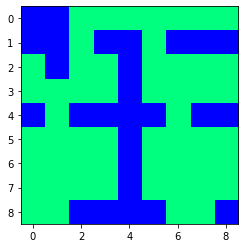

In [297]:
run_q_table = 2                  # 1, 2
if run_q_table == 1:
    plan_size = 7
    plan = np.ones((plan_size, plan_size))  # 1:free; 0: barrier
    plan[0, 1] = 0
    plan[1, [3, 4, 6]] = 0
    plan[2, [0, 1, 2, 6]] = 0
    plan[3, [4, 5]] = 0
    plan[4, [1, 2, 3]] = 0
    plan[5, 1] = 0
    plan[6, 3] = 0
else:
    plan_size = 9
    plan = np.ones((plan_size, plan_size))  # 1:free; 0: barrier
    plan[0:2,0:2] = 0
    plan[1:9, 4] = 0
    plan[1 ,[3, 4, 6, 7, 8]] = 0
    plan[2, 1] = 0
    plan[4 ,[0, 2, 3, 4, 5, 7, 8]] = 0
    plan[8, [2,3,5, 8]] = 0

plt.imshow(plan, cmap='winter')            # 'winter', 'prism', 'spring'

In [306]:
all_states = np.array((np.where(plan.T==1)[1], np.where(plan.T==1)[0]))
all_states = all_states.T
all_actions = np.array([[1, 0],[-1, 0],[0, 1],[0, -1]])       # Down(1) Up(2) Right(3) Left(4)
start_state = [8, 0]                                          # Start point
terminal_state = np.array([8, 7])                             # End point

**TD(0) algorithm:**
*Input: the policy* $\pi$ *to be evaluated*
*Algorithm parameter: step size* $\alpha \epsilon (0, 1]$
*Initialize V(s), for all* $s \epsilon S^+$, *arbitrarily expect that V(terminal)=0*
*Loop for each episode:*
*Initialize S*
*Loop for each step of episode:*
$A \leftarrow$ *action given by* $\pi$ *for S*
*Take action A, observe R,* $S^.$
$V(S) \leftarrow V(S) + \alpha[R+\lambda V(S^.)-V(S)]$
$S \leftarrow S^.$
*untile S is terminal*

In [299]:
# ======================================== Step 1:Initialization =======================================
alpha = 0.1
gamma = 0.999
Num_epochs = 500                         # Policy evaluation
V = np.zeros((np.size(all_states, 0)))
# ====================================== Step 2:Policy Evaluation =======================================
for i in tqdm(range(0, Num_epochs), desc='Number Epochs:'):
    v = np.copy(V)
    state = all_states[np.random.randint(low=0, high=len(all_states)-1, size=1),:]
    state = state.flatten()
    while 1:
        action = all_actions[np.random.randint(low=0, high=len(all_actions), size=1),:]
        action = action.flatten()
        [new_state, reward] = environment (all_states, state, action, terminal_state)    # Environment
        ind = np.argmax(np.sum(np.equal(all_states, state),axis=1))
        ind_new = np.argmax(np.sum(np.equal(all_states, new_state),axis=1))
        V[ind] = V[ind] + alpha*(reward + gamma*V[ind_new]-V[ind])
        state = new_state

        if (state==terminal_state).all():
            break
    if np.linalg.norm(V-v) < 1e-2:
        break
# ===================================== Step 3:Policy Improvement =======================================
policy = np.zeros((np.size(all_states, 0), 1), dtype=int)   # Policy improvement: selection of the best action; Down(1) Up(2) Right(3) Left(4)
for j in range(0,np.size(all_states , 0)):
    vector = np.zeros((np.size(all_actions , 0),1))
    for k in range(0, np.size(all_actions , 0)):
        [new_state, reward] = environment (all_states, all_states[j,:], all_actions[k,:], terminal_state)   # Environment
        ind = np.argmax(np.sum(np.equal( all_states, new_state),axis=1))
        vector[k] = reward + gamma*V[ind]
    ind = np.where(vector==np.max(vector))[0]
    policy[j] = ind[np.random.randint(low=0, high=len(ind), size=1)]

Number Epochs:: 100%|██████████| 500/500 [01:03<00:00,  7.87it/s]


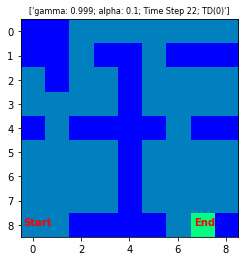

In [307]:
# ====================================== Step 4:Plot TD(0) Algorithm======================================
dis = 1                                  # dis = 1: Show plot
epsilon = 0
plot_gif = 0                             # plot_gif = 1 : Save plots
type = 'TD(0)'
Q_prediction = 0
FinalTimeStep =1000000
[states, rewards, actions, filenames] = plot(plan, all_states, all_actions,policy, FinalTimeStep,gamma, epsilon, dis, start_state, terminal_state, Q_prediction, alpha, type, plot_gif)

**Q-Learning algorithm**
*Algorithm parameters: step size* $\alpha \epsilon (0, 1]$, *small* $\epsilon > 0$
*Initialize Q(s,a), for all* $s \epsilon S^+, a\epsilon A(s)$, *arbitrarily expect that Q(terminal, .)=0*
*Loop for each episode:*
*Initialize S*
*Loop for each step of episode:*
*Choose A from S using policy derived from Q(e.g., e-greedy)*
*Take action A, observe R,* $S^.$
*Choose* $A^.$ *from* $S^.$ *using policy derived from Q(e.g., e-greedy)*
$Q(S,A) \leftarrow Q(S,A) + \alpha[R+\lambda max_a Q(S^., a)-Q(S, A)]$
$S \leftarrow S^.$
*until S is terminal*

In [312]:
# ======================================== Step 1:Initialization ========================================
alpha = 0.1                # Learning rate or step size determines to what extent newly acquired information overrides old information
gamma = 0.8                # Discount factor or gamma determines the importance of future rewards
epsilon = 0.9
Num_epochs = 500
FinalTimeStep =1000000

num_action = all_actions.shape[0]
state_actionPais = np.zeros((all_states.shape[0] * all_actions.shape[0], 4), dtype=int)
for i in range(0, all_states.shape[0]):
    state_actionPais[num_action * i:num_action + 4 * i, :] = np.concatenate((np.tile(all_states[i, :], (4, 1)), all_actions), axis=1)

counter = np.zeros((state_actionPais.shape[0], 1))
Q = np.zeros((state_actionPais.shape[0], 1))
policy = np.random.randint(low=0, high=all_actions.shape[0], size=all_states.shape[0])
# ====================================== Step 2:Policy Evaluation =======================================
for i in tqdm(range(0, Num_epochs), desc='Number Epochs:'):
    state = all_states[np.random.randint(low=0, high=len(all_states)-1, size=1),:]
    state = state.flatten()
    while 1:
        if np.random.rand(1)>epsilon:
            Ind = policy[np.argmax(np.sum(np.equal(all_states, state),axis=1))]
        else:
            Ind = np.random.randint(low=0, high=all_actions.shape[0], size=1)

        [new_state, reward] = environment (all_states, state, all_actions[Ind.item(), :], terminal_state)    # Environment

        state_action = np.concatenate((state, all_actions[Ind.item(),:]), axis=0)
        ind = np.argmax(np.sum(np.equal(state_actionPais, state_action), axis=1))
        ind_new = np.where(np.sum(np.equal(state_actionPais[:, 0:2], new_state), axis=1) == 2)[0]
        Q[ind] = Q[ind] + alpha*(reward + gamma*np.max(Q[ind_new])-Q[ind])
        state = new_state
# ===================================== Step 3:Policy Improvement =======================================
        policy = np.zeros((np.size(all_states, 0), 1), dtype=int)
        for k in range(0,np.size(all_states, 0)):
            Q_ = Q[num_action*k:num_action+4*k]
            Ind = np.where(Q_==np.max(Q_))[0]
            policy[k] = Ind[np.random.randint(low=0, high=len(Ind), size=1)]

        if (state==terminal_state).all():
            break
    epsilon = epsilon*0.97

Number Epochs:: 100%|██████████| 500/500 [00:56<00:00,  8.83it/s]


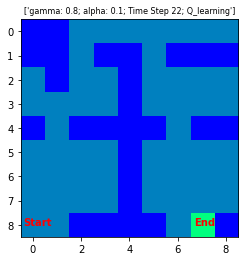

In [314]:
# =================================== Step 4:Plot Q-Learning Algorithm ==================================
dis = 1                                  # dis = 1: Show plot
epsilon = 0
plot_gif = 1                             # plot_gif = 1 : Save plots
type = 'Q_learning'
Q_prediction = 0
FinalTimeStep =1000000
[states, rewards, actions, filenames] = plot(plan, all_states, all_actions,policy, FinalTimeStep,gamma, epsilon, dis, start_state, terminal_state, Q_prediction, alpha, type, plot_gif)

**SARSA algorithm**
*Algorithm parameters: step size* $\alpha \epsilon (0, 1]$, *small* $\epsilon > 0$
*Initialize Q(s,a), for all* $s \epsilon S^+, a\epsilon A(s)$, *arbitrarily expect that Q(terminal, .)=0*
*Loop for each episode:*
*Initialize S*
*Choose A from S using policy derived from Q(e.g., e-greedy)*
*Loop for each step of episode:*
  *Take action A, observe R,* $S^.$
  *Choose* $A^.$ *from* $S^.$ *using policy derived from Q(e.g., e-greedy)*
  $Q(S,A) \leftarrow Q(S,A) + \alpha[R+\lambda Q(S^., A^.)-Q(S, A)]$
$S \leftarrow S^.; A\leftarrow A^.$
*until S is terminal*